In [1]:
from my_plot_tools import plot_confusion_matrix

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [5]:
df_fake = pd.read_csv('./fake_news_set.csv')
df_real = pd.read_csv('./real_news_set.csv').sample(df_fake.shape[0]) # due to imba dataset

In [6]:
df = pd.concat([df_real, df_fake], axis=0).sample(frac=1)

In [7]:
df.groupby('label').size()

label
0    6822
1    6822
dtype: int64

## Using only Body

In [8]:
%%time
vect = CountVectorizer(ngram_range=(2,2))
tfid = TfidfTransformer()

CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 24.1 µs


In [9]:
X = vect.fit_transform(df['body'].astype(str)).copy()
X = tfid.fit_transform(X)
y = df.loc[:, 'label'].copy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=245)
X_train.shape

(9550, 2397735)

### Naive-Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
model.score(X_test, y_test)

0.7755251587689301

Normalized confusion matrix
[[0.55002464 0.44997536]
 [0.00290557 0.99709443]]


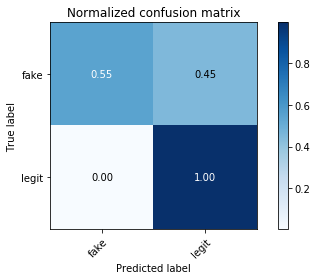

In [15]:
y_pred = model.predict(X_test)

assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title='Normalized confusion matrix');

### SVM

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
model = SGDClassifier();
model.fit(X_train, y_train);

In [18]:
model.score(X_test, y_test)

0.9467513434294089

Normalized confusion matrix
[[0.93346476 0.06653524]
 [0.0401937  0.9598063 ]]


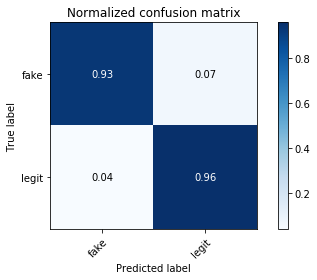

In [19]:
y_pred = model.predict(X_test)

assert y_pred.shape == y_test.shape
plot_confusion_matrix(y_test, y_pred, classes=np.array(['fake', 'legit']), normalize=True,
                      title='Normalized confusion matrix');